## DDPM diffusion model implemented with 2D data 

In [4]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.datasets import make_swiss_roll

### Prepare data 
We generate the swiss roll as the true data distribution 

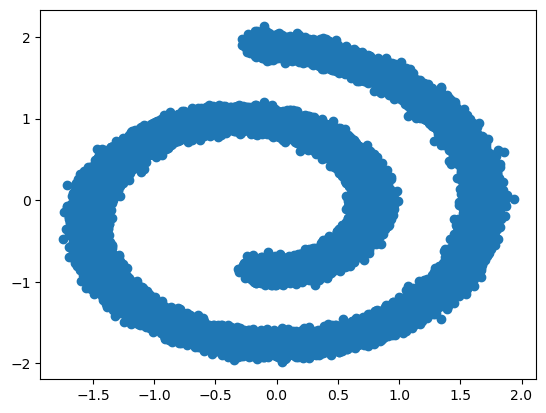

In [9]:
x,_= make_swiss_roll(n_samples=100000, noise=0.4) # noise is the extra dots that make it less like a swiss roll 
x= x[:,[0,2]]
x=  (x-x.mean())/x.std()         # normalize the x   
plt.scatter(x[:,0], x[:,1])

In [ ]:
x = torch.tensor(x,dtype=torch.float32) # (100,000 , 2 ) where each row is a cartesian coordinate 
x.shape 

/var/folders/7j/w7_7w_8x2l71rf18ty9xsp8w0000gn/T/ipykernel_2162/3703981695.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


torch.Size([100000, 2])

#### Scheduler 
Define the \beta and \alpha values for the forward and backward process. The schedule is implemented using the cos (instead of original paper's \beta and \alpha parameters)  
- Improved DDPM uses the $\beta$ and $\alpha$ scheduler similar with flow matching's intention where the mean and variance change following the change of $\alpha$ and $\beta$.  
- Here they are the opposite: where $\beta$ goes from 0 to 1, and $\alpha$ goes from 1 to 0  
- Improved DDPM offers a much simpler way of computing $\beta$ and $\alpha$ to control the mean and variance without using $\prod$ and tricks 

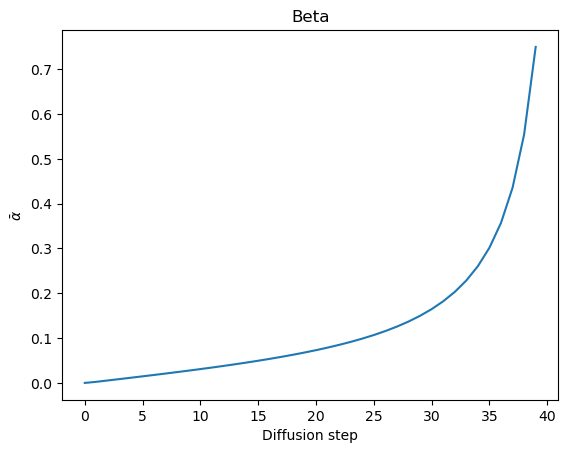

In [ ]:
diffusion_steps= 40     # t=40 
s=0.008 
timesteps= torch.tensor(range(0,diffusion_steps),dtype=torch.float32)   # make a list of time  (40,1)

# define a decreasing baralpha from 1 to close to 0 
schedule= torch.cos( (timesteps / diffusion_steps + s)  /  (1 + s) * torch.pi / 2)**2   # pairwise operation (1,40)
baralphas= schedule/schedule[0] # divide by the first term of schedule  (40,1)

# compute the beta 
# make the duplicate the first lement and replace the last one 
# beta flips the baralpha 
# normal alpha flips it back again  
betas= 1-baralphas / torch.concatenate( (baralphas[0:1], baralphas[0:-1]) ) # (40,1)
alphas= 1- betas 



sns.lineplot(betas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.title("Beta")
plt.show()

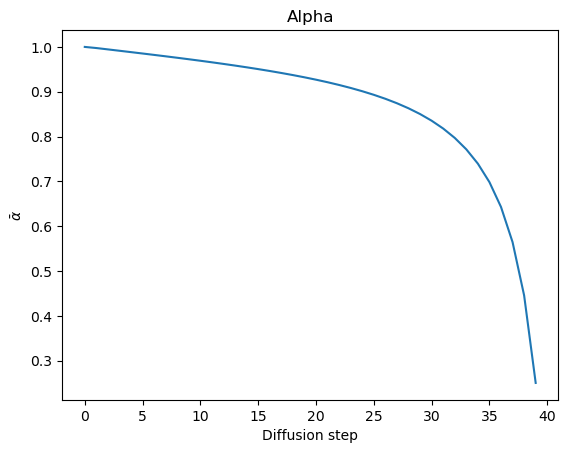

In [29]:

sns.lineplot(alphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.title("Alpha")
plt.show()

#### Forward diffusion process 
Adding a noise. We sample $\epsilon$ as a random gaussian noise. 
$X_0 = \sqrt{\text{alpha bar}} * X_t + \sqrt{\text{ 1- alpha bar}} *\epsilon $ 

In [36]:
def noise (Xbatch,t ): 
    eps= torch.randn(size=Xbatch.shape) 
    noised= (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps 

Why do they only take the 20th index here in the forward process? 

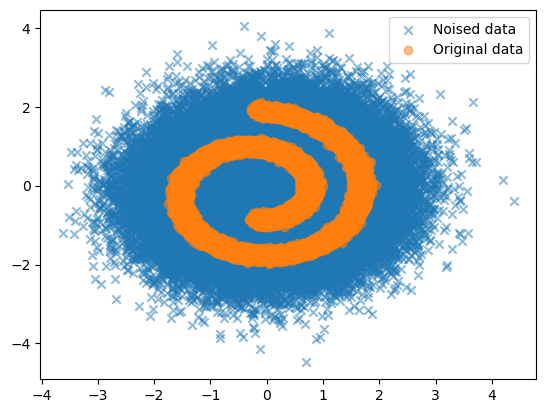

In [45]:
# denoise all the input data 
# note that here we only took the 20th index of baralpha array as the baralpha value 
noiselevel= 20 
t= torch.full([len(x),1], fill_value=noiselevel) # (100,000, 1) fill the array with noiselevel 
noised, eps= noise(x, t) 
plt.scatter(noised[:,0],noised[:,1], marker="x", alpha=0.5)
plt.scatter(x[:,0], x[:,1], alpha=0.5)
plt.legend(["Noised data", "Original data"])
plt.show() 

Denoising has a closed form solution of $$X_{t-1} = \frac{1}{\sqrt{\bar{\alpha_t}}} * (X_t - \sqrt{1-\bar{\alpha_t}} * \epsilon)$$ where $\epsilon$ is the predicted noise 

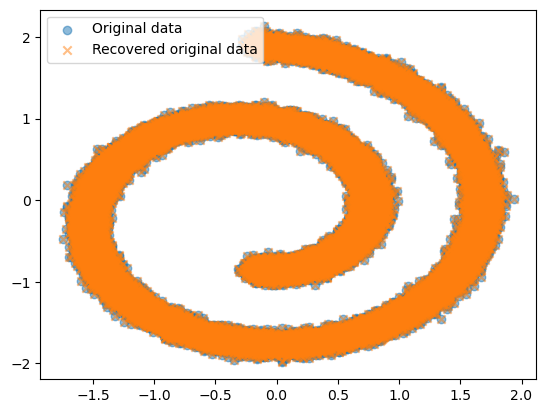

In [47]:
# because we know the noise, we can use the close form formula to get the original input back 
denoised = 1 / torch.sqrt(baralphas[noiselevel]) * (noised - torch.sqrt(1 - baralphas[noiselevel]) * eps)
plt.scatter(x[:,0], x[:,1], alpha=0.5)
plt.scatter(denoised[:,0],denoised[:,1], marker="x", alpha=0.5)
plt.legend(["Original data", "Recovered original data"])
plt.show() 

Using a diffusion model to predict the noise   
- Use the encoder and decoder structure like VAE class and U net  
 
Why add t into the model data for FC layer? 

In [54]:
import torch.nn as nn  
num_layers= 4
nunits= 64 
class DiffusionBlock (nn.Module): 
    def __init__ (self, num_layers): 
        super(DiffusionBlock,self).__init__() 
        self.linear= nn.Linear(num_layers, num_layers)  # projection of the same dimension 
    def forward(self,x):
        x= self.linear(x) 
        x= nn.functional.relu(x)    # 1 layer MLP + activation block 
        return x 
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures, num_layers, nunits): 
        super(DiffusionModel,self).__init__() 
        self.inblock= nn.Linear(nfeatures+1, nunits)    # first projection
        self.midblocks= nn.ModuleList([DiffusionBlock(nunits) for _ in range (num_layers)]) # will repeat the diffusion blocks for num_layers # of times 
        self.outblock= nn.Linear(nunits, nfeatures)
    def forward(self, x, t) -> torch.tensor: 
        val= torch.hstack([x,t])    # stack t to inputs 
        val= self.inblock(val)  
        for midblock in self.midblocks:     # looping through a set of DiffusionBlock functions 
            val= midblock(val)
        val= self.outblock (val)
        return val 

In [55]:
model = DiffusionModel(nfeatures=2, num_layers=num_layers, nunits=nunits)
model 

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-3): 4 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

Train the input data  
- Sample a random noise (noise function) with $\epsilon$ to generate a noise vector 
- sample a random time step 
- predict noise and take the L2 error   
  
- In the training process, predict the noise that is being added to the input 

In [59]:
epochs=100 
batch_size=2048 
loss_fn= nn.MSELoss() # we can use the RMSE 
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=epochs)  # learning scheduler 
for epoch in range (epochs): 
    epoch_loss= steps=0     # steps is how many steps our model has taken in the diffusion process (which is number of times we sent in the batch)
    for i in range(0, len(x), batch_size): 
        Xbatch= x[i:i+batch_size]   # take each batch
        timesteps= torch.randint(0, diffusion_steps, size=[len(Xbatch),1])  # generate random time steps for each batch 
        noised, eps= noise(Xbatch, timesteps)
        pre = model(noised, timesteps) 
        loss= loss_fn (pre, eps)    # element wise comparison between predicted noise and the actual noise generated 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        epoch_loss+= loss 
        steps+=1 
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 0.7630900144577026
Epoch 1 loss = 0.5333272218704224
Epoch 2 loss = 0.5164282917976379
Epoch 3 loss = 0.5067113637924194
Epoch 4 loss = 0.49517011642456055
Epoch 5 loss = 0.4870731830596924
Epoch 6 loss = 0.4733603298664093
Epoch 7 loss = 0.47380533814430237
Epoch 8 loss = 0.4662933051586151
Epoch 9 loss = 0.46669742465019226
Epoch 10 loss = 0.4567442834377289
Epoch 11 loss = 0.4565277099609375
Epoch 12 loss = 0.45548537373542786
Epoch 13 loss = 0.4488029479980469
Epoch 14 loss = 0.4475384056568146
Epoch 15 loss = 0.44773608446121216
Epoch 16 loss = 0.446926087141037
Epoch 17 loss = 0.4462156593799591
Epoch 18 loss = 0.4449723958969116
Epoch 19 loss = 0.44058507680892944
Epoch 20 loss = 0.4381815791130066
Epoch 21 loss = 0.4386681616306305
Epoch 22 loss = 0.44012314081192017
Epoch 23 loss = 0.435150682926178
Epoch 24 loss = 0.4376757740974426
Epoch 25 loss = 0.43607333302497864
Epoch 26 loss = 0.4370449185371399
Epoch 27 loss = 0.4381355047225952
Epoch 28 loss = 0.432898

#### Sampling
Srart with Gaussian Noise(the final distribution after T would be a normal distribution)  
  
Then predict one step before a time using the close form formula for sampling until we go back to step 0, which outputs the original paper. And this reverse sampling process is turning from the simple distribution back to the complex distribution. 

In [62]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures))
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t))
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures))
            xt += [x]
        return x, xt

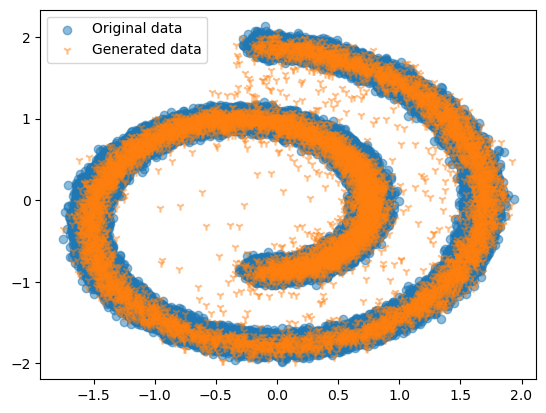

In [63]:
Xgen, Xgen_hist = sample_ddpm(model, 10000, 2)
Xgen = Xgen.cpu()
plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="1", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.show()